# Advanced Machine Learning - programming assignment 2

**Please fill in:**
* Davide Schiavi (6967620)
* Samuel Meyer (5648122)
* Riccardo Bassani (6866840)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set.

In [1]:
import numpy as np
import itertools
import graphviz # conda install python-graphviz

The graphviz can draw graphs to different file formats, or show them directly in the notebook. We will use numpy arrays to represent graphs. The following function converts such an array to a graph in graphviz format. 

In [2]:
def graph_to_graphviz(G, node_names):
    n = G.shape[0]
    d = graphviz.Digraph(engine='circo') #'neato')
    for node_name in node_names:
        d.node(node_name)
    for x in range(n):
        for y in range(n):
            if x == y:
                continue
            if G[x,y] and not G[y,x]:
                d.edge(node_names[x], node_names[y])
            elif x < y and G[x,y] and G[y,x]:
                d.edge(node_names[x], node_names[y], dir='none')
    return d

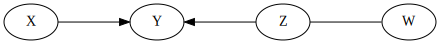

In [3]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a function that performs the PC algorithm. Add the missing code for phase 2, and implement phases 3 and 4.

In [4]:
def PC_algorithm(n, independence_tester):
    # PHASE I: Initialization
    # The matrix G represents a graph as follows:
    # - For all x, G[x,x] == False
    # - G[x,y] == False and G[y,x] == False: no edge between x and y
    # - G[x,y] == True  and G[y,x] == True:  undirected edge x --- y
    # - G[x,y] == True  and G[y,x] == False: directed edge x --> y
    G = np.logical_not(np.eye(n, dtype=bool))
    
    # PHASE II: Skeleton search
    # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
    sepset = dict()
    for k in range(n-1):
        for x in range(n):
            for y in range(n):
                if not G[x,y]:
                    continue
                # Try all subsets S of Adj(x) \ {y} with |S|=k,
                # until an independence is found.
                # Hint: use itertools.combinations
                
                # Your code here
                sets = itertools.combinations([i for i in range(n) if (i != x and i != y)], k)
                
                for S in sets:
                    indep = independence_tester.test_independence(x, y, S)
                    if indep:
                        # print("independence found: {0} and {1} given {2}".format(x,y,S))
                        G[x,y] = G[y,x] = False
                        S_mask = np.zeros(n, dtype=bool)
                        np.put(S_mask, S, True)
                        sepset[frozenset([x,y])] = S_mask
                        break
        # Do we need to continue with smaller k?
        max_S_size = np.sum(G, axis=0) - 1
        if np.all(max_S_size < k + 1):
            break

    # PHASE III: Orient v-structures
    # Something to watch out for:
    # If the data are not faithful to any graph, the algorithm may end up trying
    # to orient a single edge in two different ways. You can choose either
    # orientation if this happens.  
    
    # Your code here
    not_adj_pairs = []
    for r, row in enumerate(G):
        for c, column in enumerate(row):
            if (G[r][c] == False and not ([c,r] in not_adj_pairs) and not c==r):
                not_adj_pairs.append([r,c])
                    
    common_adjs = []
    for pair in not_adj_pairs:
        common_adj = []
        for r, row in enumerate(G):
            if (r!=pair[0] and r!=pair[1] and ((G[r,pair[0]] and G[r,pair[1]]))):
                common_adj.append(r)
        common_adjs.append(common_adj)
    
    for i,pair in enumerate(not_adj_pairs):
        z = common_adjs[i]
        for z_real in z:
            if (not(sepset[frozenset(pair)][z_real])):
                G[pair[0],z_real] = True
                G[z_real, pair[0]] = False
                G[pair[1],z_real] = True
                G[z_real, pair[1]] = False 
                break

    # PHASE IV: Orientation rules

    applied = True
    while applied:
        applied = False
        for i in range(n):
            for j in range(n):
                if (j != i) :
                    for l in range(n):
                        if (l!= i and l!=j):
                            for k in range(n):
                                if (k!=l and k!= i and k!=j and G[i][j] and (G[j][i]) and G[l][j] and not(G[j][l]) and G[k][j] and not(G[j][k]) and G[i][l] and G[l][i] and G[i][k] and G[k][i] and not(G[l][k]) and not(G[k][l])):    
                                    G[j][i] = False
                                    applied = True
                            if (G[i][j] and not(G[j][i]) and G[j][l] and not(G[l][j]) and G[i][l] and G[l][i]):
                                G[l][i] = False
                                applied = True
                            if (G[i][j] and not(G[j][i]) and G[j][l] and (G[l][j]) and not(G[i][l]) and not(G[l][i])):
                                G[l][j] = False
                                applied = True


    return G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an /oracle/ instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, PC should be able to recover the Markov equivalence class of the true graph.

In [5]:
def is_d_connected_dfs(mB, pos, w, S, vis):
    # Made modifications to deal with CPDAGs as input
    #print("At ", pos)
    (v, dir) = pos
    if v == w:
        return True
    if (dir == 0 and not S[v]) or (dir == 1 and S[v]):
        # traverse backward (dir=0) along an arrow
        next_vs_mask = np.logical_and(mB[v,:], np.logical_not(vis[:,0]))
        if dir == 1:
            # we can't continue on an undirected path in case dir == 1 and S[v])
            next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[:,v]))
        tmp = np.logical_or(vis[:,0], next_vs_mask)
        vis[:,0] = tmp
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 0), w, S, vis):
                return True
    if not S[v]:
        # traverse forward (dir=1) along an arrow
        next_vs_mask = np.logical_and(mB[:,v], np.logical_not(vis[:,1]))
        next_vs_mask = np.logical_and(next_vs_mask, np.logical_not(mB[v,:]))
        vis[:,1] = np.logical_or(vis[:,1], next_vs_mask)
        for next_v in np.nonzero(next_vs_mask)[0]:
            if is_d_connected_dfs(mB, (next_v, 1), w, S, vis):
                return True
    return False

def is_d_separated(G, v, w, S):
    if S[v] or S[w]:
        return True
    mB = G.T
    d = mB.shape[0]
    # vis[v,0]: reachable by path ending in tail
    # vis[v,1]: reachable by path ending in head
    vis = np.zeros((d,2), dtype=bool)
    pos = (v,0)
    vis[pos] = True
    is_d_connected_dfs(mB, pos, w, S, vis)
    if vis[w,0] or vis[w,1]:
        return False
    return True

class IndependenceOracle:
    def __init__(self, true_G):
        self.G = true_G
        self.n = true_G.shape[0]
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        #S_mask[S] = True
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph G1 we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

CORRECT


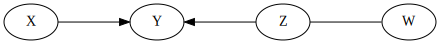

In [6]:
oracle = IndependenceOracle(G1)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G1) else "INCORRECT")
graph_to_graphviz(G, node_names)

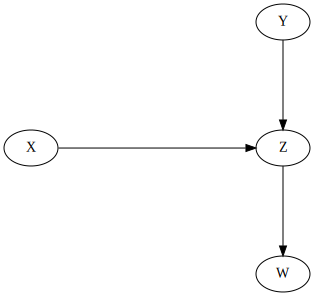

In [7]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

CORRECT


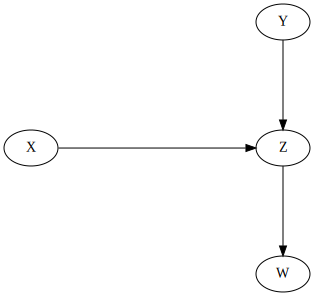

In [8]:
oracle = IndependenceOracle(G2)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G2) else "INCORRECT")
graph_to_graphviz(G, node_names)

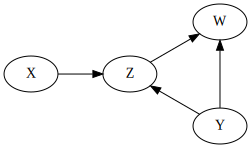

In [9]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

CORRECT


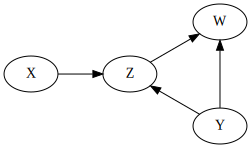

In [10]:
oracle = IndependenceOracle(G3)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G3) else "INCORRECT")
graph_to_graphviz(G, node_names)

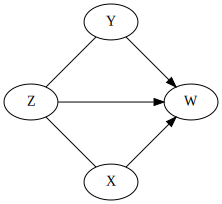

In [11]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

CORRECT


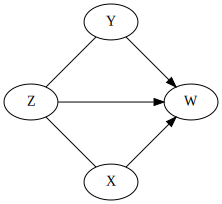

In [12]:
oracle = IndependenceOracle(G4)
G = PC_algorithm(4, oracle)
print("CORRECT" if np.all(G == G4) else "INCORRECT")
graph_to_graphviz(G, node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled 'experiment', indicates in which way that cell was prepared. We can think of experiment=1 as denoting the observational data, and other values of experiment (2 through 14) as various interventional datasets.

In [13]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking a logarithm
all_data.loc[:, all_data.columns != 'experiment'] = np.log(all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [14]:
exp1 = all_data.copy()

# Get names of indexes for which column experiemnt has not value 1
indexNames = exp1[ exp1['experiment'] != 1 ].index
 
# Delete these row indexes from dataFrame
exp1.drop(indexNames , inplace=True)

# dropping experiment column 
exp1.drop(["experiment"], axis = 1, inplace = True) 

exp1.shape

(853, 11)

In [15]:
exp1

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146
5,2.933857,1.321756,2.867899,3.095578,2.388763,2.476538,3.246491,6.413459,2.617396,3.893859,4.056989
6,3.804438,3.597312,2.341806,4.882802,2.791165,2.158715,2.884801,6.727432,2.708050,3.580737,2.895912
7,3.858622,2.708050,2.681022,3.417727,2.862201,3.005683,3.813307,6.144186,1.862529,3.194583,2.995732
8,4.644391,4.119037,2.360854,3.049273,3.732896,2.442347,3.157000,6.098074,3.374169,4.110874,3.230804
9,3.049273,3.068053,0.631272,5.323010,3.777348,2.580217,4.905275,5.361292,2.681022,3.284664,4.615121


To run the PC algorithm on data, we need to perform (conditional) independence tests. The package [tigramite](https://github.com/jakobrunge/tigramite) implements several such tests. The simplest of these tests is ParCorr(). It assumes the data come from a linear model, which they actually don't. We will use it anyway, because the alternatives (such as CMIknn() (Runge, 2018)) are more effort to install and orders of magnitude slower.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a (much) larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [16]:
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        # print("test: {0} and {1} given {2} -> pval={3}".format(x,y,S,pval))
        return pval > self.alpha

Could not import rpy package
Could not import r-package RCIT


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should have just one or two connected components.

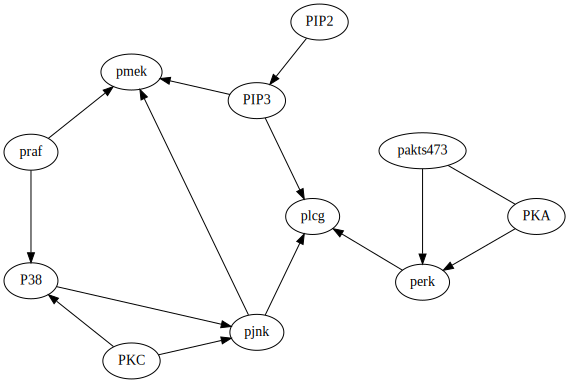

In [17]:
# With alpha = 0.4, the graph has one connected component
tester = IndependenceTester(exp1, ParCorr(), 0.4)
G = PC_algorithm(len(exp1.columns), tester)
node_names = list(exp1.columns)
graph_to_graphviz(G, node_names)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [18]:
exp1_5 = all_data.copy()

# Get names of indexes for which column experiment has not value 1,5
indexNames = exp1_5[ (exp1_5['experiment'] != 1) & (exp1_5['experiment'] != 5) ].index
 
# Delete these row indexes from dataFrame
exp1_5.drop(indexNames , inplace=True)

exp1_5

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
5,2.933857,1.321756,2.867899,3.095578,2.388763,2.476538,3.246491,6.413459,2.617396,3.893859,4.056989,1
6,3.804438,3.597312,2.341806,4.882802,2.791165,2.158715,2.884801,6.727432,2.708050,3.580737,2.895912,1
7,3.858622,2.708050,2.681022,3.417727,2.862201,3.005683,3.813307,6.144186,1.862529,3.194583,2.995732,1
8,4.644391,4.119037,2.360854,3.049273,3.732896,2.442347,3.157000,6.098074,3.374169,4.110874,3.230804,1
9,3.049273,3.068053,0.631272,5.323010,3.777348,2.580217,4.905275,5.361292,2.681022,3.284664,4.615121,1


In [19]:
exp1_6 = all_data.copy()

# Get names of indexes for which column experiemnt has not value 1,6
indexNames = exp1_6[ (exp1_6['experiment'] != 1) & (exp1_6['experiment'] != 6) ].index
 
# Delete these row indexes from dataFrame
exp1_6.drop(indexNames , inplace=True)

exp1_6

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
0,3.273364,2.580217,2.177022,2.906901,4.074142,1.888584,2.833213,6.025866,2.833213,3.804438,3.688879,1
1,3.580737,2.803360,2.509599,2.821379,2.095561,2.923162,3.481240,5.863631,1.214913,2.803360,4.119037,1
2,4.084294,3.786460,2.681022,2.322388,2.564949,2.701361,3.481240,5.998937,2.433613,3.462606,2.970414,1
3,4.290459,4.416428,3.139833,2.602690,0.254642,1.763017,2.468100,6.269096,2.617396,3.353407,3.139833,1
4,3.517498,2.985682,1.646734,2.275214,3.210844,3.049273,3.830813,5.720312,1.539015,3.246491,4.398146,1
5,2.933857,1.321756,2.867899,3.095578,2.388763,2.476538,3.246491,6.413459,2.617396,3.893859,4.056989,1
6,3.804438,3.597312,2.341806,4.882802,2.791165,2.158715,2.884801,6.727432,2.708050,3.580737,2.895912,1
7,3.858622,2.708050,2.681022,3.417727,2.862201,3.005683,3.813307,6.144186,1.862529,3.194583,2.995732,1
8,4.644391,4.119037,2.360854,3.049273,3.732896,2.442347,3.157000,6.098074,3.374169,4.110874,3.230804,1
9,3.049273,3.068053,0.631272,5.323010,3.777348,2.580217,4.905275,5.361292,2.681022,3.284664,4.615121,1


**Question**: In the dataframe for experiments 1 and 5, look at PIP2 and the variables that were adjacent to it in the output of PC. Based on looking at some plots, does the data give evidence for or against the hypothesis that psitectorigenin modifies PIP2? And what does the data for the two experiments seem to say about the directions of the arrows between PIP2 and its neighbours?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Put your answer in markdown boxes, not as comments in your code!)

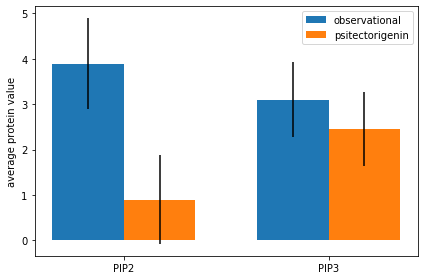

In [28]:
import matplotlib.pyplot as plt

labels = ['PIP2', 'PIP3'] #labels for experiment 1,5

exp_1a = exp1_5.loc[exp1_5['experiment'] == 1]
exp_1a = exp_1a[labels]

exp_5 = exp1_5.loc[exp1_5['experiment'] == 5]
exp_5 = exp_5[labels]

x = np.arange(len(labels))
exp1_data = list()
exp1_sdev = list()
exp2_data = list()
exp2_sdev = list()
for l in labels:
    exp1_data.append(exp_1a[l].mean())
    exp2_data.append(exp_5[l].mean())
    exp1_sdev.append(np.std(exp_1a[l]))
    exp2_sdev.append(np.std(exp_5[l]))

width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, exp1_data, width, label='observational',yerr=exp1_sdev)
rects2 = ax.bar(x + width/2, exp2_data, width, label='psitectorigenin',yerr=exp2_sdev)


#plt.bar(ind, exp1_data)
plt.xticks(x,labels)
plt.legend((rects1[0], rects2[0]), ('observational', 'psitectorigenin'))
ax.set_ylabel('average protein value')

fig.tight_layout()

plt.show()


**Answer**: The plot shows a significant decrease in the average amount of PIP2 after adding the psitectorigenin. Thus, it seems like adding psitectorigenin does indeed modify PIP2. The PC graph shows a one-directional arrows from PIP2 to PIP3. Assuming psitectorigenin only affects PIP2, the slight decrease in PIP3 could be explained as a consequence of the decrease in PIP2. The arrow from PIP2 to PIP3 would then be an accurate representation of causation.

**Answer**: A more accurate study of the correlation and the causal relationship between the two variables is required: 

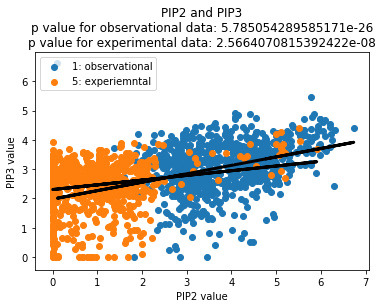

In [21]:
from scipy import stats

plt.scatter(exp_1a['PIP2'], exp_1a['PIP3'], label = "1: observational")
slope, intercept, r_value, p_value_1, std_err = stats.linregress(exp_1a['PIP2'], exp_1a['PIP3'])
plt.plot(exp_1a['PIP2'], intercept + slope*exp_1a['PIP2'], 'k', linewidth=3)

plt.scatter(exp_5['PIP2'], exp_5['PIP3'], label = "5: experiemntal")
slope, intercept, r_value, p_value_2, std_err = stats.linregress(exp_5['PIP2'], exp_5['PIP3'])
plt.plot(exp_5['PIP2'], intercept + slope*exp_5['PIP2'], 'k', linewidth=3)

plt.legend(loc = "upper left")
title = "PIP2 and PIP3\np value for observational data: " + str(p_value_1) + "\np value for experimental data: " + str(p_value_2)
plt.title(title)

x_label = plt.xlabel("PIP2 value")
y_label = plt.ylabel("PIP3 value")

**Answer**: 
The p-values confirm that there is a significant correlation between PIP2 and PIP3.
Moreover, the plot above shows how when changing the amount of PIP2, the value of PIP3 changes following approximately the same regression line of the observational case. This supports the hypothesis that PIP3 is affected by PIP2.
In conclusion, the effect of PIP2 on PIP3 is not big in size but it is statistically significant.


**Question**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables you think might be relevant. Assume it is true that adding U0126 produces an intervention on the activity of pmek. What would you expect to see in the data if the graph found by PC was correct? What changes would you propose to that graph based on the data?

Again put your answer with accompanying plots in new boxes below here.

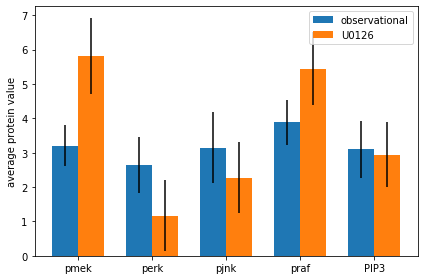

In [22]:
import matplotlib.pyplot as plt

labels = ['pmek', 'perk', 'pjnk', 'praf','PIP3'] #labels for experiment 1,6

exp_1b = exp1_6.loc[exp1_6['experiment'] == 1]
exp_1b = exp_1b[labels]

exp_6 = exp1_6.loc[exp1_6['experiment'] == 6]
exp_6 = exp_6[labels]

x = np.arange(len(labels))
exp1_data = list()
exp1_sdev = list()
exp2_data = list()
exp2_sdev = list()
for l in labels:
    exp1_data.append(exp_1b[l].mean())
    exp2_data.append(exp_6[l].mean())
    exp1_sdev.append(np.std(exp_1b[l]))
    exp2_sdev.append(np.std(exp_6[l]))

width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, exp1_data, width, label='observational',yerr=exp1_sdev)
rects2 = ax.bar(x + width/2, exp2_data, width, label='U0126',yerr=exp2_sdev)


#plt.bar(ind, exp1_data)
plt.xticks(x,labels)
plt.legend((rects1[0], rects2[0]), ('observational', 'U0126'))
ax.set_ylabel('average protein value')

fig.tight_layout()

plt.show()

**Answer**: Assuming U0126 increases activity of pmek, and not the amount, the data displayed in the plot can be only explained by the presence of a cycle: the increase in the activity of pmek could cause an increase in the amount of praf, that in turn would cause the amount of pmek to increase.
The presence of such a cycle could explain why the PC algorithm failed in identifying the correct relationships.
The graph should then be modified by adding an arrow from pmek to praf, while leaving the one in the opposite direction.

Looking at the data, perk decreases significantly: it could be affected directly by pmek or by praf. Following the beliefs that pmek only affects perk, an arrow could be drawn from pmek to perk. Nevertheless, a more detailed analysis will follow explaining why a correlation bewtween pmek and perk is indeed absent, so no the arrow must not be added.

PIP3 does not seem to vary, then it can be said that it is not affected neither by pmek nor by praf.

The amount of pjnk also varies, but not as significantly as the amount of perk: looking at this plot, it could be a child of pmek or of praf but a more detailed study will follow showing how there is no a correlation.



**Answer** : When running the PC algorithm on the experimental data (6), the graph which is found supports our conclusion, showing a dependence between pmek and praf. 

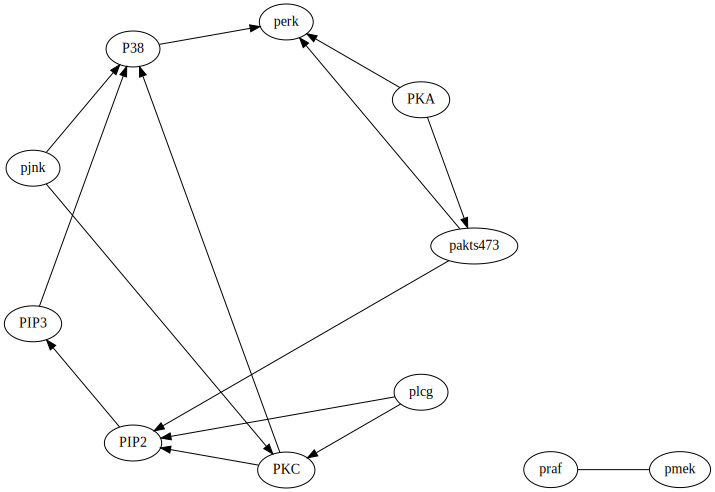

In [23]:
exp6 = all_data.copy()

# Get names of indexes for which column experiemnt has not value 1
indexNames = exp6[ exp6['experiment'] != 6 ].index
 
# Delete these row indexes from dataFrame
exp6.drop(indexNames , inplace=True)

# dropping experiment column 
exp6.drop(["experiment"], axis = 1, inplace = True) 

tester = IndependenceTester(exp6, ParCorr(), 0.4)
G = PC_algorithm(len(exp6.columns), tester)
node_names = list(exp6.columns)
graph_to_graphviz(G, node_names)

**Answer** : We will use scatter plots to analyse in detail the relationship between pmek and the relevant variables mentioned above:

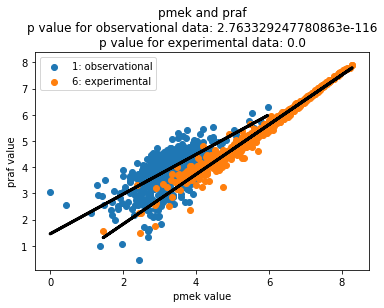

In [24]:
plt.scatter(exp_1b['pmek'], exp_1b['praf'], label = "1: observational")
slope, intercept, r_value, p_value_1, std_err = stats.linregress(exp_1b['pmek'], exp_1b['praf'])
plt.plot(exp_1b['pmek'], intercept + slope*exp_1b['pmek'], 'k', linewidth=3)

plt.scatter(exp_6['pmek'], exp_6['praf'], label = "6: experimental")
slope, intercept, r_value, p_value_2, std_err = stats.linregress(exp_6['pmek'], exp_6['praf'])
plt.plot(exp_6['pmek'], intercept + slope*exp_6['pmek'], 'k', linewidth=3)

plt.legend(loc = "upper left")
title = "pmek and praf\np value for observational data: " + str(p_value_1) + "\np value for experimental data: " + str(p_value_2)
plt.title(title)

x_label = plt.xlabel("pmek value")
y_label = plt.ylabel("praf value")

**Answer** : The p-values confirm the strong correlation between the two variables.
    The plot shows that the amount of pmek changed with the intervention: as explained before, this can only happen if a cycle is present. The most convincing explanation, supported by the plot above, is that U0126 increases the activity of pmek, this causes praf to increase, and the increased amount of praf causes pmek to increase.

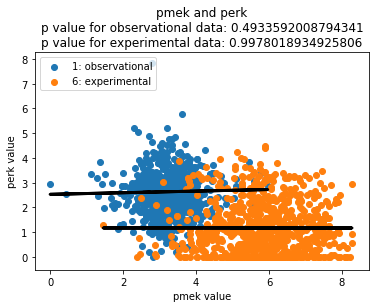

In [25]:
plt.scatter(exp_1b['pmek'], exp_1b['perk'], label = "1: observational")
slope, intercept, r_value, p_value_1, std_err = stats.linregress(exp_1b['pmek'], exp_1b['perk'])
plt.plot(exp_1b['pmek'], intercept + slope*exp_1b['pmek'], 'k', linewidth=3)

plt.scatter(exp_6['pmek'], exp_6['perk'], label = "6: experimental")
slope, intercept, r_value, p_value_2, std_err = stats.linregress(exp_6['pmek'], exp_6['perk'])
plt.plot(exp_6['pmek'], intercept + slope*exp_6['pmek'], 'k', linewidth=3)

plt.legend(loc = "upper left")
title = "pmek and perk\np value for observational data: " + str(p_value_1) + "\np value for experimental data: " + str(p_value_2)
assign_title = plt.title(title)

x_label = plt.xlabel("pmek value")
y_label = plt.ylabel("perk value")

**Answer**: The p-values and the plot contrast the impression given from the histogram above, showing how there is no correlation between pmek and perk.
The changes in perk must then be due to other factors.

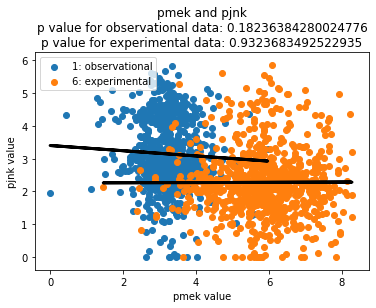

In [26]:
plt.scatter(exp_1b['pmek'], exp_1b['pjnk'], label = "1: observational")
slope, intercept, r_value, p_value_1, std_err = stats.linregress(exp_1b['pmek'], exp_1b['pjnk'])
plt.plot(exp_1b['pmek'], intercept + slope*exp_1b['pmek'], 'k', linewidth=3)

plt.scatter(exp_6['pmek'], exp_6['pjnk'], label = "6: experimental")
slope, intercept, r_value, p_value_2, std_err = stats.linregress(exp_6['pmek'], exp_6['pjnk'])
plt.plot(exp_6['pmek'], intercept + slope*exp_6['pmek'], 'k', linewidth=3)

plt.legend(loc = "upper left")
title = "pmek and pjnk\np value for observational data: " + str(p_value_1) + "\np value for experimental data: " + str(p_value_2)
assign_title = plt.title(title)

x_label = plt.xlabel("pmek value")
y_label = plt.ylabel("pjnk value")

**Answer**: The p-values and the plot confirm  there is no correlation between pmek and pjnk.

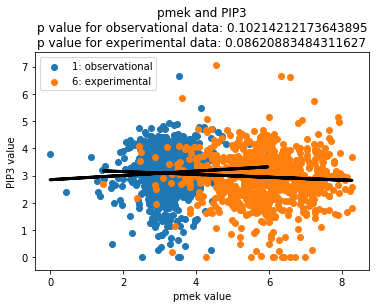

In [27]:
plt.scatter(exp_1b['pmek'], exp_1b['PIP3'], label = "1: observational")
slope, intercept, r_value, p_value_1, std_err = stats.linregress(exp_1b['pmek'], exp_1b['PIP3'])
plt.plot(exp_1b['pmek'], intercept + slope*exp_1b['pmek'], 'k', linewidth=3)

plt.scatter(exp_6['pmek'], exp_6['PIP3'], label = "6: experimental")
slope, intercept, r_value, p_value_2, std_err = stats.linregress(exp_6['pmek'], exp_6['PIP3'])
plt.plot(exp_6['pmek'], intercept + slope*exp_6['pmek'], 'k', linewidth=3)

plt.legend(loc = "upper left")
title = "pmek and PIP3\np value for observational data: " + str(p_value_1) + "\np value for experimental data: " + str(p_value_2)
assign_title = plt.title(title)

x_label = plt.xlabel("pmek value")
y_label = plt.ylabel("PIP3 value")

**Answer**: The p-values and the plot confirm  there is no correlation between pmek and PIP3.

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.